In [ ]:
!pip install -q datasets jiwer
# Install the 'datasets' and 'jiwer' Python packages using pip.
# The '-q' flag makes the installation process less verbose.

In [ ]:
import os
import time
import numpy as np
import pandas as pd

import cv2
import json
from PIL import Image

output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
from bs4 import BeautifulSoup
# Import the BeautifulSoup class from the bs4 (BeautifulSoup 4) library for parsing XML or HTML.

def get_string(file):
    # Define a function 'get_string' that takes a file path as input.

    with open(file, 'r') as f:
        # Open the specified file in read mode and assign the file object to 'f'.
        data = f.read()
        # Read the entire content of the file into the 'data' variable.

    bs_data = BeautifulSoup(data, 'xml')
    # Parse the 'data' using BeautifulSoup with 'xml' parser to create a BeautifulSoup object.

    b_unique = bs_data.find_all('object')
    # Find all occurrences of the 'object' tag in the parsed XML and store them in 'b_unique'.

    return ''.join([i.find('name').text for i in b_unique])
    # Extract the text from the 'name' tag of each 'object', join them into a single string, and return it.

def yolo_to_abs(data_dict):#, scale=100.0):
    # Define a function 'yolo_to_abs' that takes a dictionary 'data_dict' as input.

    cord = {}
    # Initialize an empty dictionary 'cord' to store the converted coordinates.

    original_width = data_dict['original_width']
    original_height = data_dict['original_height']
    # Extract the original width and height from 'data_dict'.

    pixel_x = int(data_dict['x']/100. * original_width)
    pixel_y = int(data_dict['y']/100. * original_height)
    pixel_width = int(data_dict['width']/100. * original_width)
    pixel_height = int(data_dict['height']/100. * original_height)
    # Convert the normalized YOLO coordinates (percentage) to pixel values.

    cord['x1'] = pixel_x - 2
    cord['y1'] = pixel_y - 2
    # Calculate the top-left corner coordinates by adjusting with a small offset.

    cord['x2'] = pixel_x + pixel_width + 5
    cord['y2'] = pixel_y + pixel_height + 5
    # Calculate the bottom-right corner coordinates by adding the dimensions and a small offset.

    return cord
    # Return the dictionary containing the adjusted bounding box coordinates.


In [ ]:
def preprocess(image, width: int, height: int, cval: int = 255, mode="letterbox", return_scale=False,):
    """Obtain a new image, fit to the specified size.
    Args:
        image: The input image
        width: The new width
        height: The new height
        cval: The constant value to use to fill the remaining areas of the image
        return_scale: Whether to return the scale used for the image
    Returns:
        The new image
    """
    fitted = None
    # Initialize the variable 'fitted' to hold the processed image.

    x_scale = width / image.shape[1]
    y_scale = height / image.shape[0]
    # Calculate the scaling factors for width and height based on the target size.

    if x_scale == 1 and y_scale == 1:
        fitted = image
        scale = 1
        # If the image already matches the target size, set 'fitted' to the original image and 'scale' to 1.
    elif (x_scale <= y_scale and mode == "letterbox") or (
        x_scale >= y_scale and mode == "crop"
    ):
        scale = width / image.shape[1]
        resize_width = width
        resize_height = (width / image.shape[1]) * image.shape[0]
        # If using 'letterbox' mode and x-scale is smaller or equal to y-scale,
        # or using 'crop' mode and x-scale is larger or equal to y-scale,
        # calculate the new dimensions while maintaining the aspect ratio.
    else:
        scale = height / image.shape[0]
        resize_height = height
        resize_width = scale * image.shape[1]
        # If using 'crop' mode and y-scale is smaller or equal to x-scale,
        # calculate the new dimensions while maintaining the aspect ratio.

    if fitted is None:
        resize_width, resize_height = map(int, [resize_width, resize_height])
        # Convert the calculated dimensions to integers.

        if mode == "letterbox":
            fitted = np.zeros((height, width, 3), dtype="uint8") + cval
            # Create a new image filled with the constant value 'cval' in 'letterbox' mode.

            image = cv2.resize(image, dsize=(resize_width, resize_height))
            # Resize the input image to the calculated dimensions.

            fitted[: image.shape[0], : image.shape[1]] = image[:height, :width]
            # Place the resized image into the center of the new 'letterbox' image.
        elif mode == "crop":
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            # Resize the input image to the calculated dimensions.

            fitted = image[:height, :width]
            # Crop the resized image to the target size in 'crop' mode.
        else:
            raise NotImplementedError(f"Unsupported mode: {mode}")
            # Raise an error if an unsupported mode is provided.

    if not return_scale:
        return fitted
        # Return the processed image if 'return_scale' is False.
    return fitted, scale
    # Return the processed image and the scaling factor if 'return_scale' is True.


# Process license-plate-characters-detection-ocr

In [ ]:
image_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images'
# Define the directory containing the image files.

annotations_dir = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations'
# Define the directory containing the annotation files.

lic_record = []
# Initialize an empty list to store license plate records.

for im_name in sorted(os.listdir(image_dir)):
    # Iterate over the sorted list of image file names in the image directory.

    image_path = os.path.join(image_dir, im_name)
    # Construct the full path to the image file.

    annot_path = os.path.join(annotations_dir, im_name.split('.')[0]+'.xml')
    # Construct the full path to the corresponding annotation file by changing the file extension to '.xml'.

    label_string = get_string(annot_path)
    # Retrieve the text data from the annotation file using the 'get_string' function.

    lic_record.append(dict(text=str(label_string), file_name=image_path))
    # Create a dictionary with the text data and image path, then append it to 'lic_record'.


In [ ]:
df1 = pd.DataFrame(lic_record)
# Create a DataFrame 'df1' from the list of dictionaries 'lic_record'.

df1.to_csv('/kaggle/working/lic_labels1.csv')
# Save the DataFrame 'df1' to a CSV file named 'lic_labels1.csv' in the '/kaggle/working/' directory.

df1.head()
# Display the first few rows of the DataFrame 'df1' to check its content.

,text,file_name
0,MH15TC554,/kaggle/input/license-plate-characters-detecti...
1,MH02CB4545,/kaggle/input/license-plate-characters-detecti...
2,KA031351,/kaggle/input/license-plate-characters-detecti...
3,TN0600000,/kaggle/input/license-plate-characters-detecti...
4,KA51MJ8156,/kaggle/input/license-plate-characters-detecti...


In [ ]:
df1

,text,file_name
0,MH15TC554,/kaggle/input/license-plate-characters-detecti...
1,MH02CB4545,/kaggle/input/license-plate-characters-detecti...
2,KA031351,/kaggle/input/license-plate-characters-detecti...
3,TN0600000,/kaggle/input/license-plate-characters-detecti...
4,KA51MJ8156,/kaggle/input/license-plate-characters-detecti...
...,...,...
204,MH2OBN3525,/kaggle/input/license-plate-characters-detecti...
205,MH01AR5274,/kaggle/input/license-plate-characters-detecti...
206,MH20CS1941,/kaggle/input/license-plate-characters-detecti...
207,H20CS1938,/kaggle/input/license-plate-characters-detecti...


# Process car-plate-detection dataset

In [ ]:
license_no_data = pd.read_csv('/kaggle/input/tags-licenseplate/ocr-licence-plate.csv')


license_no_data['ocr'] = license_no_data['ocr'].apply(lambda x: x.split('-')[-1])
license_no_data

,ocr,id,bbox,label,transcription,annotator,annotation_id,created_at,updated_at,lead_time
0,Cars430.png,431,"[{""x"": 11.066398390342053, ""y"": 72.5, ""width"":...","[{""x"": 11.066398390342053, ""y"": 72.5, ""width"":...",BCG-986,1,314,2023-03-09T11:29:21.270803Z,2023-03-09T11:29:21.270849Z,11.090
1,Cars429.png,430,"[{""x"": 32.62032085561498, ""y"": 41.851106639839...","[{""x"": 32.62032085561498, ""y"": 41.851106639839...",KA1SER,1,313,2023-03-09T11:29:07.437858Z,2023-03-09T11:29:07.437904Z,13.608
2,Cars427.png,428,"[{""x"": 41.04627766599598, ""y"": 43.699731903485...","[{""x"": 41.04627766599598, ""y"": 43.699731903485...",01 CC 1A 0001,1,312,2023-03-09T11:28:48.305793Z,2023-03-09T11:28:48.305844Z,13.518
3,Cars426.png,427,"[{""x"": 41.85110663983904, ""y"": 68.632707774798...","[{""x"": 41.85110663983904, ""y"": 68.632707774798...",CRAIG,1,311,2023-03-09T11:28:30.687784Z,2023-03-09T11:28:30.687842Z,13.059
4,Cars425.png,426,"[{""x"": 42.45472837022133, ""y"": 46.320346320346...","[{""x"": 42.45472837022133, ""y"": 46.320346320346...",G526JHD,1,310,2023-03-09T11:28:14.569265Z,2023-03-09T11:28:14.569302Z,20.648
...,...,...,...,...,...,...,...,...,...,...
309,Cars4.png,5,"[{""x"": 26.559356136820927, ""y"": 25.42372881355...","[{""x"": 26.559356136820927, ""y"": 25.42372881355...",PUI8BES,1,5,2023-03-09T07:34:52.009265Z,2023-03-09T07:34:52.009298Z,24.077
310,Cars3.png,4,"[{""x"": 35.2112676056338, ""y"": 55.7142857142857...","[{""x"": 35.2112676056338, ""y"": 55.7142857142857...",DZI7YXR,1,4,2023-03-09T07:34:25.449170Z,2023-03-09T07:34:25.449216Z,13.863
311,Cars2.png,3,"[{""x"": 57.29972246043483, ""y"": 43.923670974270...","[{""x"": 57.29972246043483, ""y"": 43.923670974270...",PRE-NUP,1,3,2023-03-09T07:34:08.941012Z,2023-03-09T07:34:08.941056Z,17.317
312,Cars1.png,2,"[{""x"": 34.390806447042095, ""y"": 51.59992211332...","[{""x"": 34.390806447042095, ""y"": 51.59992211332...",PG-MN112,1,2,2023-03-09T07:27:38.964069Z,2023-03-09T07:27:38.964130Z,45.524


In [ ]:
lic_record = []
# Initialize an empty list to store the license plate records.

path_car_img = "/kaggle/input/car-plate-detection/images"
# Define the directory containing car plate images.

os.makedirs("/kaggle/working/images/", exist_ok=True)
# Create the directory '/kaggle/working/images/' if it does not already exist.

for row, val in license_no_data.iterrows():
    # Iterate over each row of the DataFrame 'license_no_data'.

    img_dir = os.path.join(path_car_img, val['ocr'])
    # Construct the full path to the image file using the OCR file name.

    image = cv2.imread(img_dir, cv2.IMREAD_ANYCOLOR)
    # Read the image from the constructed path using OpenCV.

    try:
        label_s = json.loads(val['transcription'])
        # Try to parse the 'transcription' field from JSON format.
    except ValueError:
        label_s = str(val['transcription'])
        # If JSON parsing fails, use the 'transcription' field as a string.

    for num, bbox in enumerate(json.loads(val['bbox'])):
        # Iterate over each bounding box in the 'bbox' field.

        path_to_save = f"/kaggle/working/images/{val['ocr'].split('.')[0]}_{num}.jpg"
        # Construct the path to save the cropped image.

        cart_cord = yolo_to_abs(bbox)
        # Convert the YOLO bounding box coordinates to absolute pixel coordinates.

        crop_img = image[cart_cord['y1']:cart_cord['y2'], cart_cord['x1']:cart_cord['x2']]
        # Crop the image using the calculated bounding box coordinates.

        crop_img = preprocess(crop_img, width=200, height=100)
        # Preprocess the cropped image to fit the specified width and height.

#         process_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY) #.astype("float32")[..., np.newaxis]
        # Optional: Convert the preprocessed image to grayscale (commented out).

        im_croped = Image.fromarray(crop_img)
        # Convert the preprocessed image array to a PIL Image object.

        im_croped.save(path_to_save)
        # Save the PIL Image object to the specified path.

        if isinstance(label_s, list):
            lic_record.append(dict(text=str(label_s[num]), file_name=path_to_save))
            # If 'label_s' is a list, append a dictionary with the label and file path to 'lic_record'.
        else:
            lic_record.append(dict(text=str(label_s), file_name=path_to_save))
            # If 'label_s' is not a list, append a dictionary with the label and file path to 'lic_record'.


In [ ]:
df2 = pd.DataFrame(lic_record)
df2.to_csv('/kaggle/working/lic_labels.csv')

df2.sort_values('file_name', inplace=True)
df2

,text,file_name
339,KL01CA2555,/kaggle/working/images/Cars0_0.jpg
243,WW 95550,/kaggle/working/images/Cars100_0.jpg
242,68-611-36,/kaggle/working/images/Cars102_0.jpg
241,NL60LXB,/kaggle/working/images/Cars104_0.jpg
240,J966S,/kaggle/working/images/Cars105_0.jpg
...,...,...
247,KA05MG1909,/kaggle/working/images/Cars97_0.jpg
246,YWORRY,/kaggle/working/images/Cars98_0.jpg
244,2662,/kaggle/working/images/Cars99_0.jpg
245,KA-09,/kaggle/working/images/Cars99_1.jpg


## Mixing datasets

In [ ]:
from sklearn.model_selection import train_test_split
# Import the train_test_split function from scikit-learn for splitting data into training and validation sets.

test_df = pd.concat([df1[-21:], df2[-21:]])
# Combine the last 21 rows from both 'df1' and 'df2' into 'test_df' for the test set.

df = pd.concat([df1[:-21], df2[:-21]])
# Combine all rows except the last 21 from both 'df1' and 'df2' into 'df' for the training and validation sets.

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)
# Split 'df' into training and validation sets with 20% of the data used for validation.
# Set the random_state to 0 for reproducibility.

train_df.reset_index(drop=True, inplace=True)
# Reset the index of 'train_df' to start from zero, dropping the old index.

valid_df.reset_index(drop=True, inplace=True)
# Reset the index of 'valid_df' to start from zero, dropping the old index.

test_df.reset_index(drop=True, inplace=True)
# Reset the index of 'test_df' to start from zero, dropping the old index.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
print(df1.shape, df2.shape)
print(train_df.shape, valid_df.shape,test_df.shape)

(209, 2) (340, 2)
(405, 2) (102, 2) (42, 2)


# Download/Load Model

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# Import the TrOCRProcessor and VisionEncoderDecoderModel classes from the transformers library.

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
# Load the TrOCRProcessor, which is used to process images and prepare them for the TrOCR model.
# The 'microsoft/trocr-base-printed' checkpoint contains a pretrained TrOCR model for printed text.

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
# Load the VisionEncoderDecoderModel, which combines the vision and text encoder-decoder architectures.
# This model is suitable for tasks where visual information (from images) needs to be converted to text.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import Dataset
# Import the torch library and Dataset class from torch.utils.data for creating a custom dataset.

class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        # Store the root directory where image files are located.
        self.df = df
        # Store the DataFrame containing file names and texts.
        self.processor = processor
        # Store the processor for image and text processing.
        self.max_target_length = max_target_length
        # Store the maximum length for text labels.

    def __len__(self):
        return len(self.df)
        # Return the number of samples in the dataset.

    def __getitem__(self, idx):
        # Retrieve an item from the dataset based on the index 'idx'.
        file_name = self.df['file_name'][idx]
        # Get the file name for the image at the given index.
        text = self.df['text'][idx]
        # Get the corresponding text label for the image at the given index.

        # Prepare the image (i.e., resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        # Open the image file and convert it to RGB format.
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # Process the image using the processor and obtain pixel values as tensors.

        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length).input_ids
        # Tokenize and encode the text, padding it to the maximum length.

        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        # Replace PAD token IDs with -100 so they are ignored by the loss function.

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        # Create a dictionary with 'pixel_values' and 'labels' for the sample.

        return encoding
        # Return the encoded sample.

    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
        # Implement an iterator to allow iteration over the dataset.


In [ ]:
root_dir = ''
# Define the root directory where image files are located (currently empty, should be set to the appropriate path).

train_dataset = LPDataset(root_dir, df=train_df, processor=processor)
# Create an instance of LPDataset for the training data using 'train_df' and the 'processor'.

test_dataset = LPDataset(root_dir, df=test_df, processor=processor)
# Create an instance of LPDataset for the test data using 'test_df' and the 'processor'.

eval_dataset = LPDataset(root_dir, df=valid_df, processor=processor)
# Create an instance of LPDataset for the validation data using 'valid_df' and the 'processor'.


In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Print ids, text (for testing a single image on loaded processor) for a single image

In [ ]:
# Set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
# Set the start token ID for the decoder using the CLS token ID from the processor's tokenizer.

model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set the padding token ID for the model using the PAD token ID from the processor's tokenizer.

# Make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# Ensure that the vocabulary size of the model is set correctly to match the decoder's vocabulary size.

# Set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
# Set the end-of-sequence (EOS) token ID for the model using the SEP token ID from the processor's tokenizer.

model.config.max_length = 64
# Set the maximum length for generated sequences to 64 tokens.

model.config.early_stopping = True
# Enable early stopping to stop beam search if the model generates an EOS token.

model.config.no_repeat_ngram_size = 3
# Prevent the model from repeating any n-gram of size 3 during beam search.

model.config.length_penalty = 2.0
# Apply a length penalty of 2.0 to encourage the generation of longer sequences.

model.config.num_beams = 4
# Set the number of beams for beam search to 4, which controls the number of parallel hypotheses considered.


In [ ]:
processor.tokenizer('AOCED', padding="max_length", max_length=50).input_ids

# guess :D (notebook ran on colab, thus this cell is not executed)

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    # Extract the label IDs from the prediction object.

    pred_ids = pred.predictions
    # Extract the predicted IDs from the prediction object.

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    # Decode the predicted IDs into strings, skipping special tokens.

    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    # Replace -100 (used for padding) with the actual PAD token ID in the label IDs.

    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    # Decode the adjusted label IDs into strings, skipping special tokens.

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    # Compute the Character Error Rate (CER) between the predicted and reference strings using the CER metric.

    return {"cer": cer}
    # Return the computed CER as a dictionary with the key "cer".


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
# Import the Seq2SeqTrainer and Seq2SeqTrainingArguments classes, as well as the default data collator, from the transformers library.

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    # Enable generation for prediction, allowing the model to produce text outputs.

    evaluation_strategy="steps",
    # Set the evaluation strategy to be based on steps rather than epochs.

    per_device_train_batch_size=8,
    # Set the batch size for training to 8 examples per device.

    per_device_eval_batch_size=8,
    # Set the batch size for evaluation to 8 examples per device.

    overwrite_output_dir=True,
    # Allow overwriting of the output directory if it already exists.

    output_dir=output_dir,
    # Specify the directory where model checkpoints and outputs will be saved.

    logging_steps=2,
    # Log training information every 2 steps.

    save_steps=500,
    # Save model checkpoints every 500 steps.

    eval_steps=200,
    # Evaluate the model every 200 steps.

    report_to="none",
    # Disable reporting to external tools or services.

    num_train_epochs=3,
    # Set the number of training epochs to 3.
)


# Instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    # Set the model to be used for training and evaluation.

    tokenizer=processor.feature_extractor,
    # Set the tokenizer to be used for processing inputs and outputs.

    args=training_args,
    # Pass the training arguments to the trainer.

    compute_metrics=compute_metrics,
    # Specify the function to compute metrics for evaluation.

    train_dataset=train_dataset,
    # Provide the dataset to be used for training.

    eval_dataset=eval_dataset,
    # Provide the dataset to be used for evaluation.

    data_collator=default_data_collator,
    # Set the data collator to handle batching of data, using the default collator.
)


/opt/conda/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
train_time = time.time() ## in UTC time
trainer.train()
train_time = time.time() - train_time

print('Train time (sec)', train_time)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


Train time (sec) 162.139506816864


In [ ]:
save_time = time.time()
# Record the current time to measure the model saving time.

model.save_pretrained("/kaggle/working/vit-ocr")
# Save the pretrained model to the specified directory.

save_time = time.time() - save_time
# Calculate the time taken to save the model by subtracting the recorded start time from the current time.

print('save_time time (sec)', save_time)
# Print the time taken to save the model in seconds.


save_time time (sec) 2.0748815536499023


In [ ]:
score_model = VisionEncoderDecoderModel.from_pretrained('/kaggle/working/vit-ocr')
print(score_model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

# Inference

In [ ]:
file_image = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0055.png'
# Define the path to the image file.

# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
# Optional: This line is commented out but it would open an image from a URL if used.

image = Image.open(file_image).convert("RGB")
# Open the image file and convert it to RGB format.

score_time = time.time()
# Record the current time to measure inference time.

pixel_values = processor(image, return_tensors="pt").pixel_values
# Process the image using the processor and obtain pixel values as tensors.

# text = "industry, ' Mr. Brown commented icily. ' Let us have a"
# Optional: This line is commented out but it would define a sample text.

# if torch.cuda.is_available():
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set the device to GPU if available; otherwise, use CPU.

pixel_values = pixel_values.to(device)
# Move the pixel values tensor to the specified device (GPU or CPU).

# # inference
generated_ids = model.generate(pixel_values)
# Use the model to generate predictions from the pixel values.

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# Decode the generated IDs into text, skipping special tokens. Take the first item from the batch.

print(generated_text)
# Print the generated text.

score_time = time.time() - score_time
# Calculate the time taken for the inference by subtracting the recorded start time from the current time.

print('score_time (sec)', score_time)
# Print the inference time in seconds.


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


MH20TC640B
score_time (sec) 0.4162747859954834


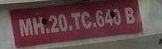

In [ ]:
image

In [ ]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
# Import necessary libraries: numpy for numerical operations, matplotlib for plotting, and SequenceMatcher for string comparison.

def compare_string(true_label, pred_label):
    # Define a function to compare two strings: the true label and the predicted label.

    true_label = true_label.replace(" ", "").replace('-','').replace('0','O')
    # Preprocess the true label by removing spaces, hyphens, and replacing '0' with 'O'.

    pred_label = pred_label.replace(" ", "").replace('-','').replace('0','O')
    # Preprocess the predicted label similarly by removing spaces, hyphens, and replacing '0' with 'O'.

    if pred_label == true_label:
        return True
        # Return True if the preprocessed predicted label matches the preprocessed true label.

    return False
    # Return False if there is no match between the preprocessed labels.


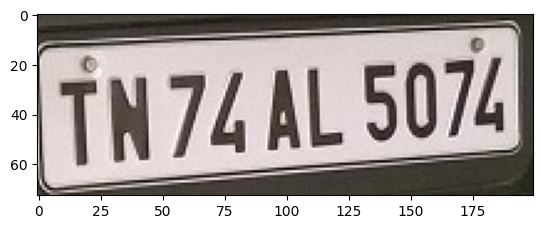

true_label TN74A5L074
pred_label TN74AL5074


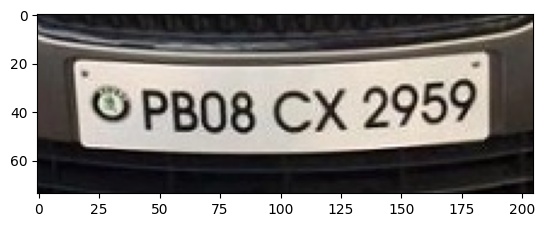

true_label PB08CX2959
pred_label OP08CX2959


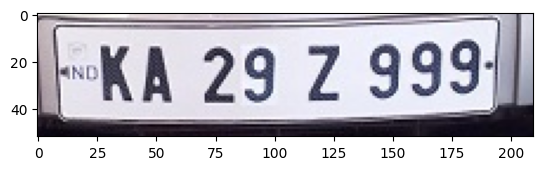

true_label AA29Z999
pred_label KA29Z999


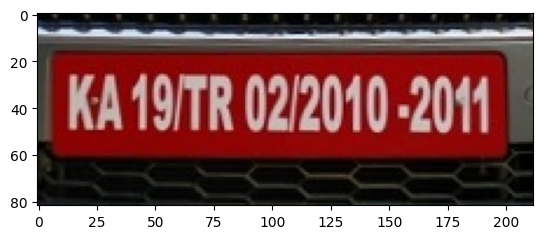

true_label KA19TR0220102011
pred_label KA19TR02010-2011


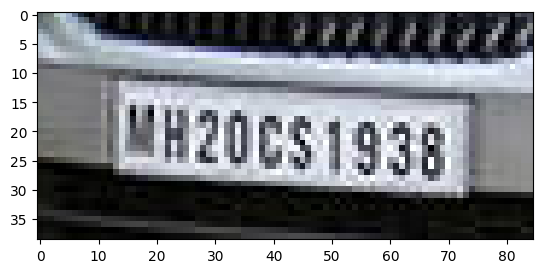

true_label H20CS1938
pred_label MH20CS1938


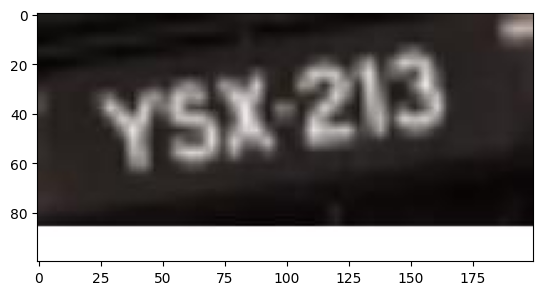

true_label YSX-213
pred_label Y5X-213


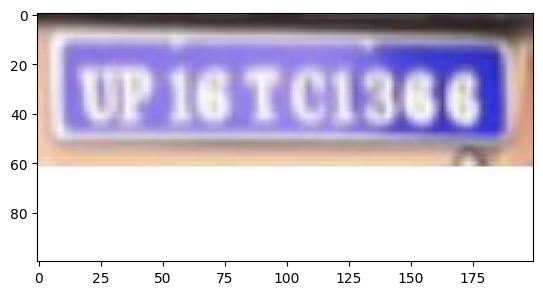

true_label UP16TC1366
pred_label UP10T01300


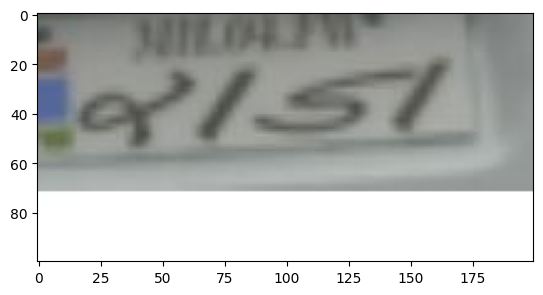

true_label A151
pred_label Q1ST


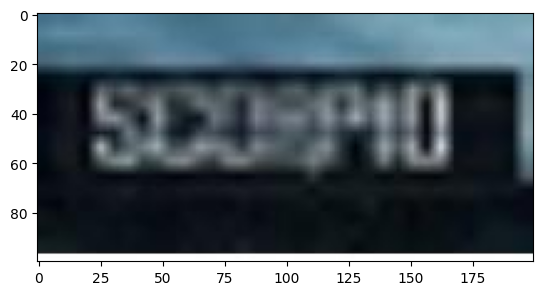

true_label SCORPIO
pred_label SM4-PT0


In [ ]:
correct_char = 0
total_char = 0
correct = 0
# Initialize counters for correct characters, total characters, and correct predictions.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set the device to GPU if available; otherwise, use CPU.

for _, val in test_df.iterrows():
    # Iterate over each row in the test DataFrame.

    image = Image.open(val['file_name']).convert("RGB")
    # Open the image file specified by 'file_name' and convert it to RGB format.

    pixel_values = processor(image, return_tensors="pt").pixel_values
    # Process the image to obtain pixel values as tensors.

    pixel_values = pixel_values.to(device)
    # Move the pixel values tensor to the specified device (GPU or CPU).

    generated_ids = model.generate(pixel_values)
    # Use the model to generate predictions from the pixel values.

    pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    # Decode the generated IDs into text, skipping special tokens. Take the first item from the batch.

    true_label = val['text']
    # Get the true label text from the DataFrame.

    # pr = prediction[i]
    # tr = y_true[i]
    # Commented out: These lines are placeholders for additional code.

    # total_char += len(true_label)
    # Commented out: This line is intended to add the length of the true label to the total character count.

    correct_char += SequenceMatcher(None, true_label, pred_label).ratio()
    # Compute the similarity ratio between the true label and the predicted label using SequenceMatcher.
    # Add this ratio to the correct_char counter.

    # for j in range(min(len(true_label), len(pred_label))):
    #     if true_label[j] == pred_label[j]:
    #         correct_char += 1
    # Commented out: This block is intended for a character-by-character comparison of labels.

    if compare_string(true_label, pred_label):
        # Check if the predicted label matches the true label using the compare_string function.
        correct += 1
        # Increment the correct prediction counter if there is a match.
    else:
        plt.imshow(np.asarray(image))
        plt.show()
        # Display the image if the prediction does not match the true label.

        print('true_label', true_label)
        # Print the true label.

        print('pred_label', pred_label)
        # Print the predicted label.


# Result on test dataset

In [ ]:
print(f'correct {correct}, total {len(test_df)}')
print('performance on test  data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/test_df.shape[0]))
print('Correct words predicted      : %.2f%%' %(correct*100/test_df.shape[0]))

correct 33, total 42
performance on test  data
Correct characters predicted : 92.69%
Correct words predicted      : 78.57%
